In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from src.algoritmos import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

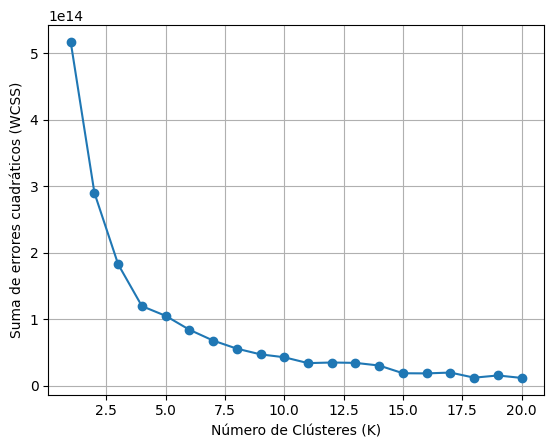

In [2]:

ruta_csv = 'data/clustering.csv'  
df = pd.read_csv(ruta_csv)

X = df[['A', 'B']].values  

graf_ganancias_decrecientes(X,20)


In [17]:
graf_clusters(X, 13)

KeyboardInterrupt: 

In [ ]:
ruta_csv = 'data/clustering.csv'  
df = pd.read_csv(ruta_csv)

X = df[['A', 'B']].values  



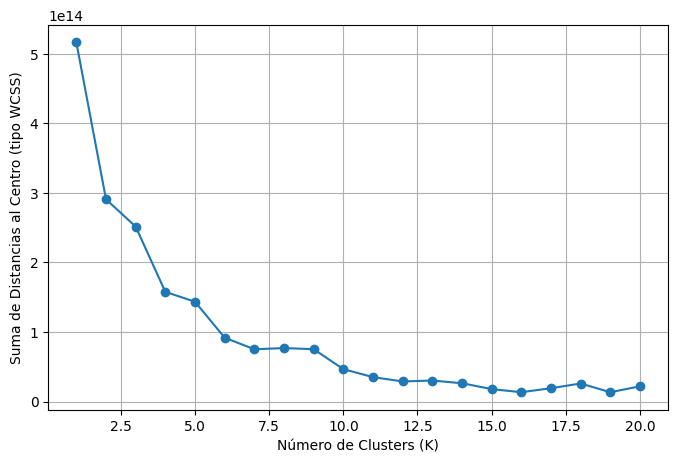

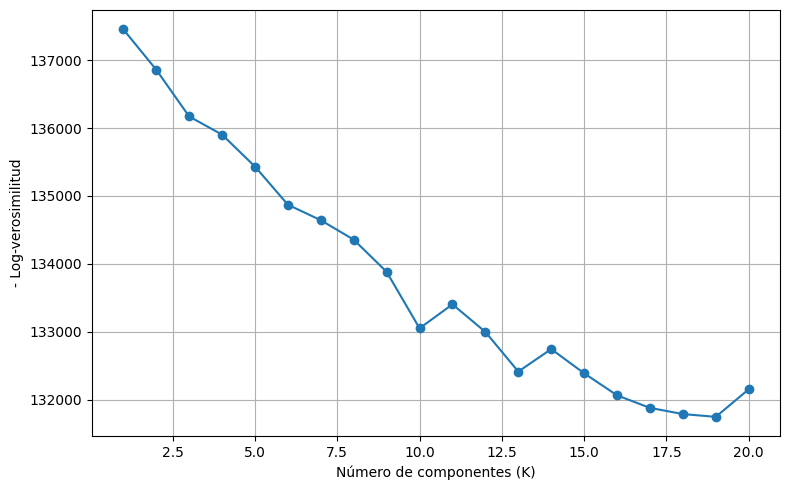

In [5]:
graf_ganancias_decrecientes_gmm_distancia(X, 20)
plot_neg_log_likelihood_vs_k(X, 20)


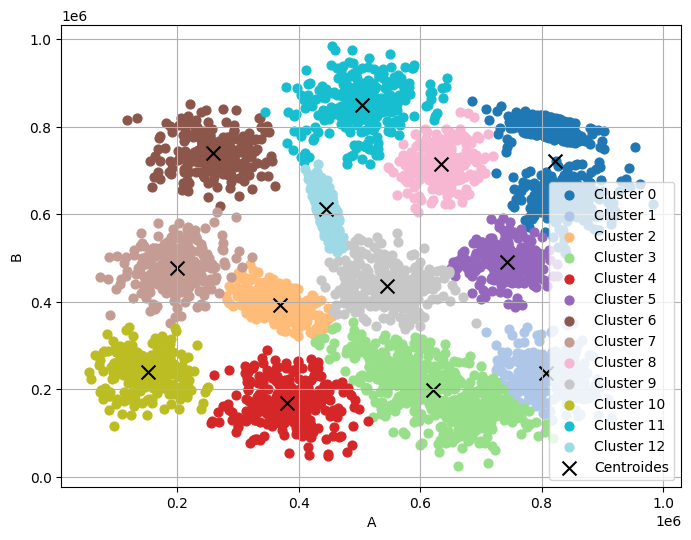

In [ ]:
gmm = GMM(13)
gmm.fit(X)
plot_cluster_GMM(X,gmm)

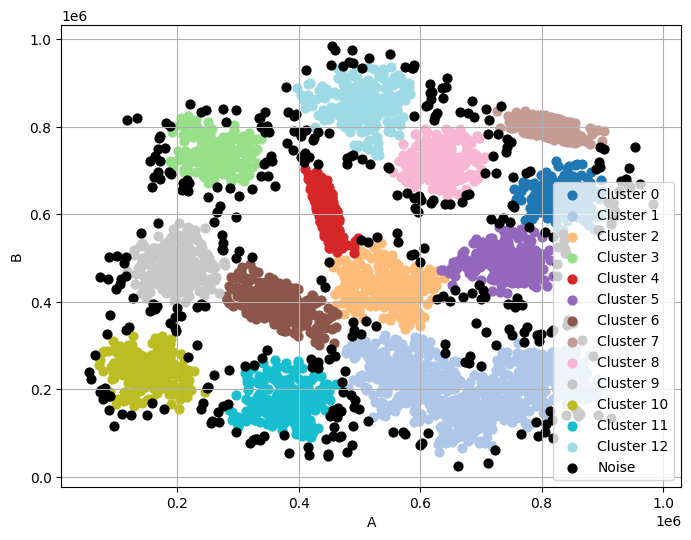

In [7]:
ruta_csv = 'data/clustering.csv'  
df = pd.read_csv(ruta_csv)

X = df[['A', 'B']].values
labels = dbscan(X, eps=24000, min_samples=11)
plot_cluster_DBSCAN(X, labels)

## 2

Min: 0.0, MaX: 1.0


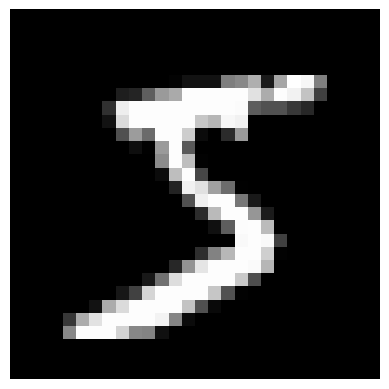

In [8]:
ruta_csv = 'data/MNIST_dataset.csv'  
df = pd.read_csv(ruta_csv)
X_sin_labels = df.drop(columns=["label"])
X = X_sin_labels / 255
print(f"Min: {X.iloc[0].values.min()}, MaX: {X.iloc[0].values.max()}")
image = X.iloc[0].values.reshape(28, 28)
plt.imshow(image, cmap='gray')
plt.axis('off')  
plt.show()


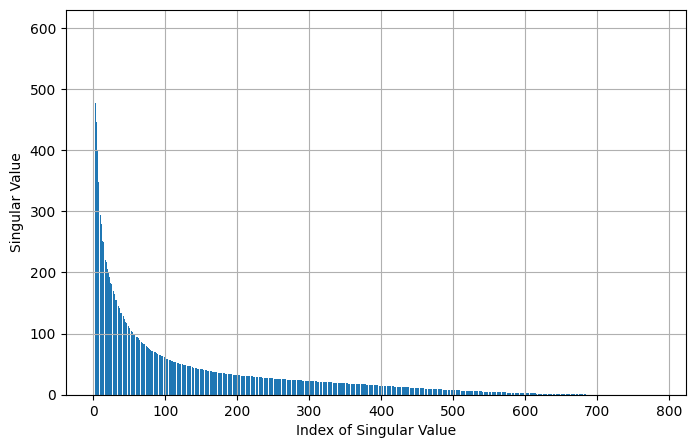

In [9]:
pca_10 = PCA_SVD(10)
pca_10.fit(X)
pca_10.plot_singular_values()

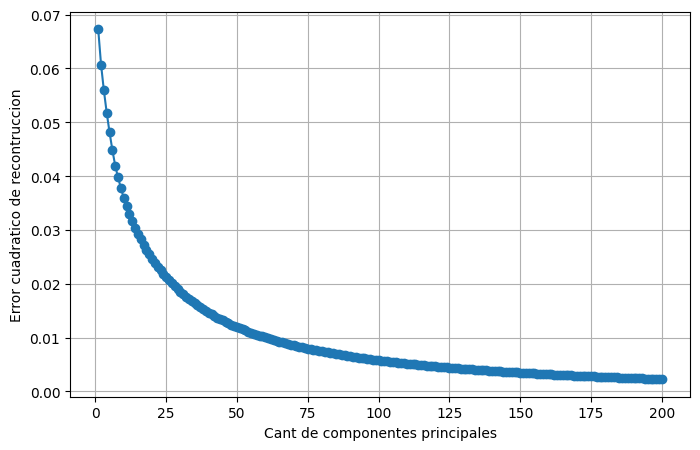

In [10]:
errors = []
max_components = 200
for n_components in range(max_components):
    pca = PCA_SVD(n_components)
    pca.fit(X)
    error = pca.reconstruction_error(X)
    errors.append(error)

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_components + 1), errors, marker='o')
plt.xlabel('Cant de componentes principales')
plt.ylabel('Error cuadratico de recontruccion')
plt.grid(True)
plt.show()

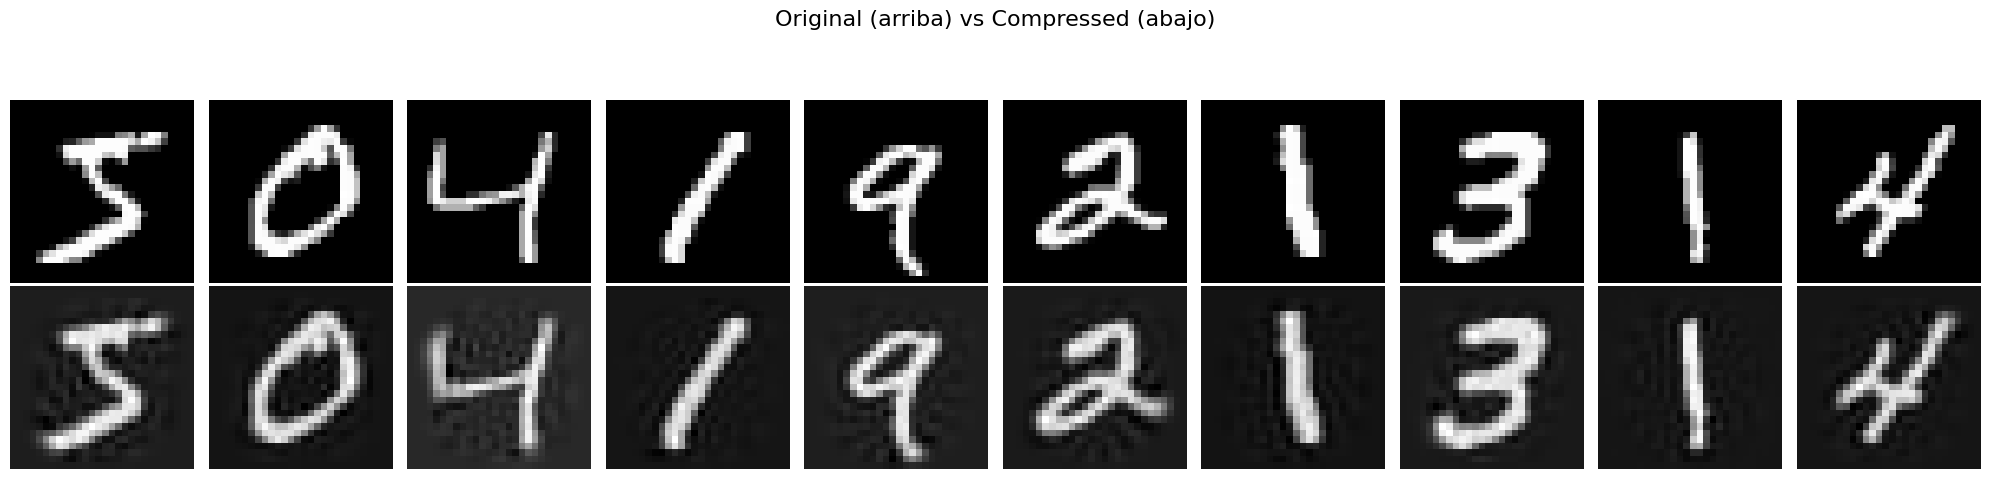

In [14]:
X = X.to_numpy() if hasattr(X, 'to_numpy') else X

# Fit PCA
pca_ideal = PCA_SVD(200)
pca_ideal.fit(X)
Z = pca_ideal.transform(X)
X_reduced = pca_ideal.inverse_transform(Z)

# Reconstrucción en forma de imagen
X_images = X.reshape((X.shape[0], 28, 28))
X_reduced_images = X_reduced.reshape((X_reduced.shape[0], 28, 28))

# Mostrar imágenes horizontalmente: 2 filas (Original, Compressed) × 10 columnas
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 5))
fig.suptitle("Original (arriba) vs Compressed (abajo)", fontsize=16)

for i in range(10):
    # Fila 0: Original
    axes[0, i].imshow(X_images[i], cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel("Original", fontsize=12)

    # Fila 1: Compressed
    axes[1, i].imshow(X_reduced_images[i], cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel("Compressed", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()



## VAE

Epoch 1, Train Loss: 170.66, Val Loss: 133.01
Epoch 2, Train Loss: 125.25, Val Loss: 119.50
Epoch 3, Train Loss: 116.42, Val Loss: 114.10
Epoch 4, Train Loss: 112.57, Val Loss: 111.43
Epoch 5, Train Loss: 110.45, Val Loss: 109.93
Epoch 6, Train Loss: 109.13, Val Loss: 108.70
Epoch 7, Train Loss: 108.15, Val Loss: 108.32
Epoch 8, Train Loss: 107.45, Val Loss: 107.62
Epoch 9, Train Loss: 106.85, Val Loss: 107.02
Epoch 10, Train Loss: 106.41, Val Loss: 106.50


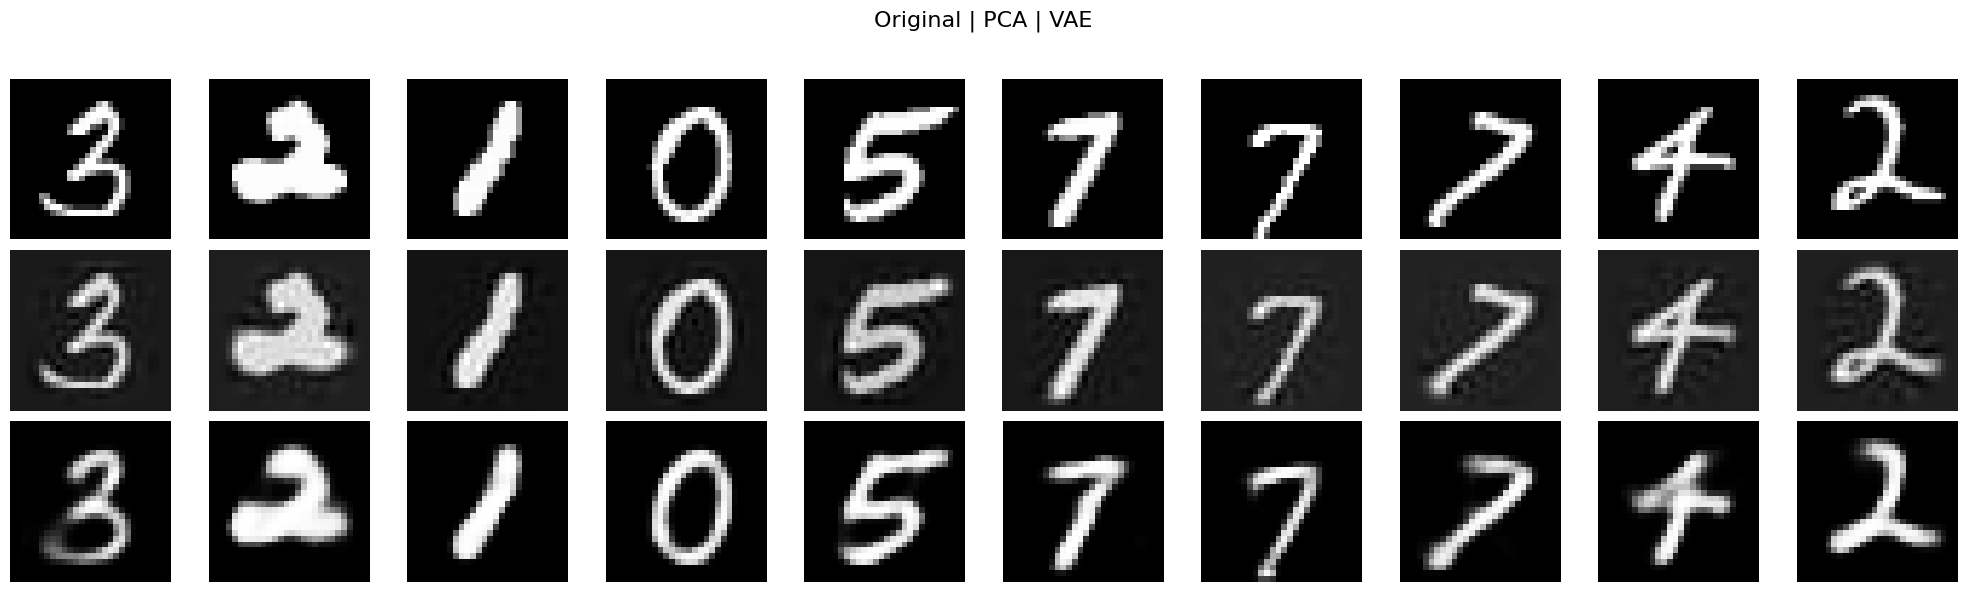

In [13]:
def train_val_split(array, seed=42):
    np.random.seed(seed)
    n_samples = len(array)
    indices = np.random.permutation(n_samples)
    split_point = int(n_samples * 0.8)
    train_idx, val_idx = indices[:split_point], indices[split_point:]
    return array[train_idx], array[val_idx]

# === División y Dataset ===

X_train, X_val = train_val_split(X)

# Crear datasets con etiquetas dummy (no se usan)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.zeros(len(X_train)))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.zeros(len(X_val)))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

# === VAE ===

class VAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=30, hidden_dim=400):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# === Entrenamiento ===

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_epoch(loader):
    model.train()
    total_loss = 0
    for x, _ in loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader.dataset)

def validate_epoch(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            loss = vae_loss(recon_x, x, mu, logvar)
            total_loss += loss.item()
    return total_loss / len(loader.dataset)

# === Loop de entrenamiento ===
epochs = 10
for epoch in range(epochs):
    train_loss = train_epoch(train_loader)
    val_loss = validate_epoch(val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}")

# === Comparación VAE vs PCA ===

# Obtener 10 imágenes de validación
x_val_batch, _ = next(iter(val_loader))
x_val_batch = x_val_batch[:10].to(device)

# Reconstrucción con VAE
model.eval()
with torch.no_grad():
    recon_vae, _, _ = model(x_val_batch)

# Reconstrucción con PCA
x_val_np = x_val_batch.cpu().numpy()

# Suponiendo que ya hiciste PCA con scikit-learn previamente:
Z = pca_ideal.transform(x_val_np)
X_reduced = pca_ideal.inverse_transform(Z)

# Mostrar imágenes horizontalmente: 3 filas (Original, PCA, VAE) × 10 columnas
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 6))
fig.suptitle("Original | PCA | VAE", fontsize=16)

for i in range(10):
    # Fila 0: Original
    axes[0, i].imshow(x_val_np[i].reshape(28, 28), cmap="gray")
    axes[0, i].axis("off")
    if i == 0: axes[0, i].set_ylabel("Original", fontsize=12)

    # Fila 1: PCA
    axes[1, i].imshow(X_reduced[i].reshape(28, 28), cmap="gray")
    axes[1, i].axis("off")
    if i == 0: axes[1, i].set_ylabel("PCA", fontsize=12)

    # Fila 2: VAE
    axes[2, i].imshow(recon_vae[i].cpu().numpy().reshape(28, 28), cmap="gray")
    axes[2, i].axis("off")
    if i == 0: axes[2, i].set_ylabel("VAE", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



In [16]:
def mse(original, reconstructed):
    return np.mean((original - reconstructed) ** 2)

def psnr(original, reconstructed):
    mse_val = mse(original, reconstructed)
    if mse_val == 0:
        return float('inf')
    return 20 * np.log10(1.0 / np.sqrt(mse_val))  # suponiendo [0, 1]

def ssim_single(img1, img2):
    # Usamos el método clásico de SSIM (simplificado)
    mu_x = img1.mean()
    mu_y = img2.mean()
    sigma_x = img1.var()
    sigma_y = img2.var()
    sigma_xy = ((img1 - mu_x) * (img2 - mu_y)).mean()
    
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim = ((2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)) / \
           ((mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2))
    return ssim

def ssim_batch(originals, reconstructions):
    scores = [ssim_single(o.reshape(28, 28), r.reshape(28, 28)) for o, r in zip(originals, reconstructions)]
    return np.mean(scores)

def print_per_image_metrics(originals, pca_recons, vae_recons):
    print("\n=== Métricas por imagen (Top 10) ===")
    print(f"{'Img':<5} {'MSE_PCA':>10} {'MSE_VAE':>10} {'PSNR_PCA':>10} {'PSNR_VAE':>10} {'SSIM_PCA':>10} {'SSIM_VAE':>10}")
    for i in range(len(originals)):
        orig = originals[i]
        pca_rec = pca_recons[i]
        vae_rec = vae_recons[i]
        mse_pca = mse(orig, pca_rec)
        mse_vae = mse(orig, vae_rec)
        psnr_pca = psnr(orig, pca_rec)
        psnr_vae = psnr(orig, vae_rec)
        ssim_pca = ssim_single(orig.reshape(28, 28), pca_rec.reshape(28, 28))
        ssim_vae = ssim_single(orig.reshape(28, 28), vae_rec.reshape(28, 28))
        print(f"{i:<5} {mse_pca:10.5f} {mse_vae:10.5f} {psnr_pca:10.2f} {psnr_vae:10.2f} {ssim_pca:10.5f} {ssim_vae:10.5f}")

print_per_image_metrics(
    x_val_np[:10],
    X_reduced[:10],
    recon_vae[:10].cpu().numpy()
)


=== Métricas por imagen (Top 10) ===
Img      MSE_PCA    MSE_VAE   PSNR_PCA   PSNR_VAE   SSIM_PCA   SSIM_VAE
0        0.10129    0.01670       9.94      17.77    0.41925    0.87546
1        0.18828    0.01078       7.25      19.67    0.30474    0.96451
2        0.15108    0.00357       8.21      24.47    0.02230    0.97999
3        0.15131    0.00783       8.20      21.06    0.08992    0.95866
4        0.11790    0.01641       9.28      17.85    0.42730    0.92374
5        0.09464    0.00863      10.24      20.64    0.50688    0.94411
6        0.10922    0.00922       9.62      20.35    0.21088    0.91988
7        0.12376    0.00821       9.07      20.85    0.35365    0.94202
8        0.09548    0.01282      10.20      18.92    0.22029    0.91969
9        0.14059    0.01754       8.52      17.56    0.14077    0.89519
